In [1]:
%matplotlib inline
import os
import shutil
import cv2
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
base_path = r"FIRST YOLO_DIABETIC RETINOPATHY/data"

folders = [
    "images/train", "images/val",
    "labels/train", "labels/val"
]

for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)
    
print("folder created Successfully")

folder created Successfully


In [3]:

base_original = r"/kaggle/input/segmentation-file-zipped/A. Segmentation/1. Original Images"
base_target = r"FIRST YOLO_DIABETIC RETINOPATHY/data/images"

sets = {
    "a. Training Set":'train',
    "b. Testing Set": 'val'
}

for src_folder, dst_folder in sets.items():
    src_path = os.path.join(base_original, src_folder)
    dst_path = os.path.join(base_target, dst_folder)
    os.makedirs(dst_path, exist_ok=True)
    
    for file in os.listdir(src_path):
        if file.lower().endswith(".jpg"):
            shutil.copy2(os.path.join(src_path, file), os.path.join(dst_path, file))
            
    print(f"Copied {src_folder} → {dst_folder}")

Copied a. Training Set → train
Copied b. Testing Set → val


In [15]:

image_dir = r"/kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/images/train"
mask_root_dir = r"/kaggle/input/segmentation-file-zipped/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
output_label_dir = r"/kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/train"

os.makedirs(output_label_dir, exist_ok=True)


class_folders = {
    "1. Microaneurysms": 0,
    "2. Haemorrhages": 1,
    "3. Hard Exudates": 2,
    "4. Soft Exudates": 3
}

merged_labels = defaultdict(list)

for lesion_folder, class_id in class_folders.items():
    mask_folder = os.path.join(mask_root_dir, lesion_folder)
    print(f"Processing: {lesion_folder}...")

    for filename in os.listdir(mask_folder):
        if not filename.lower().endswith(".tif"):
            continue

        image_id = "_".join(filename.split("_")[:2])  # IDRiD_01
        image_name = image_id + ".jpg"
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Skipped: {image_name} not found in images/train/")
            continue

        img = Image.open(image_path)
        img_w, img_h = img.size

        mask_path = os.path.join(mask_folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Could not load: {filename}")
            continue

        # Ensure 3 channels
        if len(mask.shape) == 2:
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        elif mask.shape[2] == 4:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2BGR)

        hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

        
        lower_red = np.array([0, 0, 50])
        upper_red = np.array([180, 255, 255])
        binary = cv2.inRange(hsv, lower_red, upper_red)

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w < 3 or h < 3:
                continue

            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            merged_labels[image_id].append(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")


for image_id, lines in merged_labels.items():
    label_path = os.path.join(output_label_dir, image_id + ".txt")
    with open(label_path, "w") as f:
        f.write("\n".join(lines))

print("YOLO labels generated and merged for training set!")

Processing: 1. Microaneurysms...
Processing: 2. Haemorrhages...
Processing: 3. Hard Exudates...
Processing: 4. Soft Exudates...
YOLO labels generated and merged for training set!


In [16]:

image_dir = r"/kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/images/val"
mask_root_dir = r"/kaggle/input/segmentation-file-zipped/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
output_label_dir = r"/kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/val"

os.makedirs(output_label_dir, exist_ok=True)


class_folders = {
    "1. Microaneurysms": 0,
    "2. Haemorrhages": 1,
    "3. Hard Exudates": 2,
    "4. Soft Exudates": 3
}

from collections import defaultdict

merged_labels = defaultdict(list)

for lesion_folder, class_id in class_folders.items():
    mask_folder = os.path.join(mask_root_dir, lesion_folder)
    print(f"Processing: {lesion_folder}...")

    for filename in os.listdir(mask_folder):
        if not filename.lower().endswith(".tif"):
            continue

        image_id = "_".join(filename.split("_")[:2])  # IDRiD_55
        image_name = image_id + ".jpg"
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Skipped: {image_name} not found in images/val/")
            continue

        img = Image.open(image_path)
        img_w, img_h = img.size

        mask_path = os.path.join(mask_folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Could not load: {filename}")
            continue

        if len(mask.shape) == 2:
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        elif mask.shape[2] == 4:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2BGR)

        hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)


        lower_red = np.array([0, 0, 50])
        upper_red = np.array([180, 255, 255])

        binary = cv2.inRange(hsv, lower_red, upper_red)

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w < 3 or h < 3:
                continue

            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            merged_labels[image_id].append(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

for image_id, lines in merged_labels.items():
    label_path = os.path.join(output_label_dir, image_id + ".txt")
    with open(label_path, "w") as f:
        f.write("\n".join(lines))

print("All labels merged and saved in YOLO format!")

Processing: 1. Microaneurysms...
Processing: 2. Haemorrhages...
Processing: 3. Hard Exudates...
Processing: 4. Soft Exudates...
All labels merged and saved in YOLO format!


In [17]:
yaml_content = """\
train: /kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/images/train
val: /kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/images/val
nc: 4
names: ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates"]
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created!")

data.yaml created!


In [18]:
#!pip install ultralytics
import warnings
from ultralytics import YOLO

# Suppress matplotlib and numpy warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


model = YOLO("yolov8m.pt")

model.train(
    data='data.yaml',
    batch=8,
    epochs=250,
    imgsz=1024,
    name="yolov8_diabetic_retinopathy"
)

results = model.val(plots=False, verbose=False, augment=True)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_diabetic_retinopathy4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

train: Scanning /kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/train.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1488.7±1329.0 MB/s, size: 367.3 KB)


val: Scanning /kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/val... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 528.95it/s]

val: New cache created: /kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/val.cache


Plotting labels to runs/detect/yolov8_diabetic_retinopathy4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_diabetic_retinopathy4
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      11.9G       2.67      4.562       1.43       1556       1024: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         27       5774   0.000209   0.000364   0.000109   4.09e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      13.7G      2.554      3.184      1.257       1869       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         27       5774      0.146     0.0787     0.0668     0.0276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      12.2G      2.452      2.252      1.132       2729       1024:  43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      3/250      13.5G      2.387      2.133      1.105       1689       1024: 100%|██████████| 7/7 [00:21<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         27       5774      0.212      0.194      0.126     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      14.2G      2.399      1.912       1.09       1731       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         27       5774      0.246       0.22      0.176     0.0761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      13.2G      2.327      1.778      1.116       1550       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         27       5774       0.26      0.224      0.159     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250        13G      2.346      1.683      1.093       1942       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.285      0.254      0.188     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      13.3G      2.321      1.864      1.102       1969       1024: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         27       5774      0.254      0.256      0.188     0.0802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      13.2G      2.478      1.755      1.075       1788       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774        0.4      0.228      0.231      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      14.2G      2.407      1.631      1.073       1534       1024: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.341      0.271      0.224     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      13.5G      2.351      1.596      1.111       1656       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         27       5774      0.278        0.3      0.211     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250        13G      2.426      1.652      1.069       1544       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.422      0.248      0.272      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      12.3G      2.329      1.729      1.084       1120       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         27       5774      0.355      0.309      0.278      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      14.5G      2.447       1.62      1.119       1290       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         27       5774      0.294      0.333      0.262       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      14.1G      2.374      1.727        1.1       1170       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         27       5774      0.294      0.333      0.262       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      14.3G      2.369      1.616      1.101       2028       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         27       5774      0.331      0.278      0.233     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      13.3G       2.35      1.559      1.081       1607       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.361      0.304      0.261      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      13.8G      2.268      1.476      1.083       1398       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.406      0.284      0.275      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      14.1G      2.309       1.54      1.069       1555       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         27       5774      0.335      0.309      0.267      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      13.6G      2.361      1.568      1.093       2127       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         27       5774      0.456      0.298      0.298      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      11.7G      2.263      1.485      1.079       2250       1024: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.464      0.311      0.324      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      13.5G      2.287      1.398       1.07       2628       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.373      0.306      0.295      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      13.4G      2.268      1.551      1.109       1785       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.373      0.306      0.295      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250        14G      2.233      1.415      1.056       1247       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.374      0.312      0.303      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      12.7G      2.229      1.546      1.059        527       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.356      0.319        0.3      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      14.4G       2.27      1.423      1.051       1516       1024: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.361      0.285      0.278       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      13.4G      2.207      1.391      1.046       1670       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.443      0.276      0.295      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      12.1G      2.188      1.419      1.095       1198       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         27       5774      0.396      0.321      0.303      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      11.1G      2.145      1.332      1.073       1328       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.429      0.294      0.309      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      13.4G      2.206      1.353      1.036       2098       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.377      0.321      0.313      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      13.3G      2.201      1.343      1.034       1336       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.377      0.321      0.313      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250        14G      2.176      1.315      1.016       1783       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.393      0.326       0.28      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      13.6G      2.096      1.265      1.017       1927       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         27       5774      0.391      0.312      0.294      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      14.2G      2.087      1.222      1.027       1502       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.393      0.333      0.327      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      13.6G      2.104       1.25      1.023       1834       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.413      0.322      0.333      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250        12G      2.083      1.237      1.018       2251       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.449      0.332      0.344      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      14.1G      2.127      1.232      1.048        794       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         27       5774      0.396      0.311      0.292      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      13.9G      2.168      1.317      1.008       1152       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.413       0.33      0.308      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      12.7G      2.109      1.282      1.003       2494       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.413       0.33      0.308      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      13.1G       2.11      1.303      1.041       1355       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.386      0.361      0.341      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      14.1G      2.099      1.241       1.01       1694       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.429      0.328      0.351      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      14.1G      2.079      1.216      1.004       1757       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.459      0.357      0.366      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      13.9G      2.032      1.229     0.9939       1851       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.454      0.377      0.373       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      13.7G      2.045      1.247      1.013       1361       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.429      0.336      0.353      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      14.3G      2.055      1.225      1.006        949       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.429      0.374      0.354      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      11.5G      2.057      1.218      1.014       1314       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.423      0.366      0.353      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      14.1G      2.024      1.163     0.9951       1490       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.423      0.366      0.353      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      14.1G      2.052      1.194     0.9933       1321       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774       0.43      0.329      0.327      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      13.2G      2.067      1.178      1.008       1585       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.462      0.329      0.329      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250        13G      2.073      1.181     0.9797       1427       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.458      0.327      0.328      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      13.4G      1.981      1.153      0.984       1749       1024: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.448      0.319      0.328      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250        14G      2.025      1.194      1.007       1315       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774       0.44      0.329      0.341      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      13.3G          2       1.12     0.9718       2038       1024: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.425      0.386      0.365      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      13.4G      1.932      1.105     0.9841       1368       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.478      0.346      0.371      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      13.2G      2.044      1.163      1.013       2133       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.478      0.346      0.371      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      13.7G      2.042      1.167     0.9803       1678       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.447      0.358       0.37      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250        14G      1.979      1.128      1.006        903       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.487      0.345      0.382      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      13.5G      1.957      1.138     0.9743       1618       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.505      0.347      0.395      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      12.4G      1.926      1.068     0.9669       1608       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.504      0.331      0.383      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      14.4G      1.906      1.082     0.9836       2073       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.501      0.323      0.365      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      13.3G      1.961      1.089     0.9856       2605       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.489      0.357      0.378      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      13.9G       1.95      1.111     0.9828        662       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.482      0.361      0.368      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      12.7G      1.936      1.077     0.9596       1710       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.482      0.361      0.368      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      12.7G      1.954      1.074     0.9632       1763       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.459      0.388      0.369      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      13.4G      1.932      1.116     0.9491       1841       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.348      0.392      0.357      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      14.1G      1.932      1.065     0.9761       2840       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.434      0.313      0.359      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      8.49G       1.89      1.026     0.9613       2231       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.459      0.347      0.368      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      14.5G      1.987      1.077     0.9605       2104       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.485      0.326      0.366      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      12.3G      2.003      1.093      1.004       2188       1024: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.508      0.328      0.366      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      13.4G      1.951      1.076     0.9989       2304       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.436      0.329      0.345      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250        14G      1.937      1.066     0.9769       1405       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.436      0.329      0.345      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250        14G      1.914      1.054     0.9689       1345       1024: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.437      0.302      0.353      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      10.7G      1.897      1.064     0.9637       1394       1024: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774       0.47      0.329      0.352      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      13.8G       1.97      1.135     0.9644       1533       1024: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.424      0.342      0.357      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      11.3G      1.915      1.092     0.9565       2488       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.455      0.331      0.356      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      13.4G      1.867      1.027     0.9549       1790       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.427      0.353      0.352      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      12.8G      1.828      1.038     0.9906       1373       1024: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.482      0.354      0.355      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250        12G       1.91      1.067     0.9678       2038       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         27       5774      0.476      0.342      0.346      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      14.5G      1.893      1.061     0.9503       1041       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.476      0.342      0.346      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      13.9G      1.941      1.082     0.9493       1592       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.455       0.34      0.347      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      12.7G      1.877       1.07     0.9644       1561       1024: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.465      0.343      0.356      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      12.6G      1.851      1.007     0.9446       1162       1024: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.472      0.368      0.364      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      13.9G      1.762     0.9718     0.9555       1623       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.469      0.373      0.367      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      13.2G      1.792      1.022     0.9461        954       1024: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.448      0.389      0.367      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      12.8G      1.838     0.9954     0.9338       1352       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.515      0.359      0.363      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      12.7G      1.797     0.9873     0.9288       2159       1024: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.509      0.343      0.352      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      14.4G      1.887      1.037     0.9551       1627       1024: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.509      0.343      0.352      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250        14G      1.818     0.9737     0.9324       2173       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774       0.44      0.364      0.348      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      14.3G       1.77     0.9532     0.9334       1679       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.436      0.386       0.36      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250        12G       1.76     0.9504     0.9366       1519       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         27       5774      0.438      0.382      0.358      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250        14G      1.778     0.9683     0.9337       1281       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.406       0.39      0.354       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      13.3G      1.693     0.8912     0.9319       1407       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.391      0.394      0.349      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      13.7G      1.727     0.9289     0.9129       2152       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.418      0.379      0.356      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      14.4G      1.749     0.9436     0.9364       1029       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.437      0.383      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      13.2G      1.765     0.9541     0.9392       1187       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.437      0.383      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      13.2G      1.796     0.9373     0.9213       1524       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.413       0.37      0.359      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      13.2G      1.774       0.95      0.945       1790       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774       0.45      0.331      0.349       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      13.6G      1.742     0.9154     0.9208       2327       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.501      0.287      0.347      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      13.9G      1.774     0.9331     0.9346       1036       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.469      0.314      0.364      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      14.4G        1.7     0.9086     0.9346       1498       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.453      0.373       0.38       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      14.2G      1.766     0.9248     0.9207       1891       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         27       5774      0.506      0.306      0.369      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      13.7G      1.715     0.9108     0.9082       1620       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.468      0.324      0.357      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      13.9G       1.74      0.903     0.9109       1088       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.468      0.324      0.357      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      14.3G      1.701     0.9103     0.9262        949       1024: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774       0.46      0.304      0.334      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      12.2G      1.677     0.8901     0.9054       1656       1024: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.446      0.324      0.331      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      13.2G      1.742     0.9234      0.929       1616       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.459      0.323       0.34      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      13.6G      1.726     0.9303     0.9047       1108       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.477      0.343      0.361      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      14.6G      1.731     0.9158     0.9225       1584       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.463      0.328      0.355      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      12.8G      1.729     0.9092     0.8996       1594       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         27       5774      0.439      0.339      0.359      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      13.8G      1.633     0.8705      0.914       1332       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.494      0.345      0.368      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      12.6G      1.705     0.9043     0.9259       2819       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.494      0.345      0.368      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250        14G       1.64     0.8751     0.9128       1813       1024: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.435      0.354      0.365      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      10.7G      1.645     0.8875     0.9156       1918       1024: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.437      0.391      0.366      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      11.7G       1.64     0.8702      0.919       1496       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.424      0.373       0.36      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250        14G       1.78     0.9386     0.9261       1005       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.453      0.346      0.361      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      13.8G      1.658     0.8742     0.9133       1416       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.475      0.341      0.356      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      14.4G      1.661     0.8824     0.9154       1236       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774       0.46      0.374       0.37      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      13.9G      1.632     0.8765     0.9001       2504       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774       0.51       0.35      0.375      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      12.5G      1.713     0.9248     0.9337       1169       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774       0.51       0.35      0.375      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      13.6G      1.602     0.8481     0.8888       1432       1024: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.465      0.361      0.378      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      11.6G      1.619     0.8488     0.8893       1240       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.484      0.355      0.371      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      11.1G      1.633     0.8454     0.8919       2162       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.472      0.359      0.373      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      13.8G      1.702     0.9122     0.9158        720       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.453      0.372       0.37      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      13.4G      1.643     0.8786     0.9017        521       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         27       5774      0.472      0.361       0.37      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      13.7G      1.681     0.8772     0.8814       1697       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         27       5774      0.468      0.351      0.365      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      13.9G      1.564     0.8248     0.8945       2153       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.492      0.352      0.373      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      14.4G      1.685     0.8476     0.8923       2012       1024: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.492      0.352      0.373      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      14.1G      1.611      0.863     0.8954       3031       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.491      0.349      0.371      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      11.8G      1.653     0.8549     0.8822       1466       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.467      0.346      0.349       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      14.4G      1.636      0.843     0.9065       1708       1024: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.467      0.336      0.353      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      13.7G      1.608     0.8253      0.897       1788       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         27       5774      0.466      0.351      0.374      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      12.4G      1.593     0.8117     0.8999       1698       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.461      0.376      0.378      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      13.2G      1.618     0.8259     0.8943       1819       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.493      0.357      0.373      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      13.7G      1.585     0.8345      0.908       1182       1024: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         27       5774      0.499      0.346      0.367      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      13.7G      1.625      0.834      0.898       1649       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.499      0.346      0.367      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      13.7G      1.605     0.8227     0.8914       1396       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.478       0.36      0.368       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      13.8G      1.613     0.8402     0.8956        893       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.492      0.343      0.372      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      12.5G      1.591     0.8055     0.8776       2026       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         27       5774      0.463       0.34       0.36      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      12.8G      1.653     0.8423     0.8858       2171       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.436      0.352      0.353      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      14.1G       1.59     0.8299     0.8713       3128       1024:  57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    139/250      12.8G      1.604     0.8335     0.8905       1199       1024: 100%|██████████| 7/7 [00:21<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         27       5774      0.471       0.34      0.356       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      14.6G      1.602     0.8197     0.8774       1376       1024: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.429      0.354      0.351      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      14.3G      1.531     0.7997     0.8891        958       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.441      0.361      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      13.3G      1.523     0.7939     0.8768        764       1024: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774      0.441      0.361      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      14.1G      1.558     0.8084     0.8861       1934       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.445      0.348      0.347      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      12.7G      1.553     0.7952     0.8772       1610       1024: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774       0.46      0.343      0.347      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      14.4G      1.602     0.8152     0.8886       1308       1024: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         27       5774      0.463      0.349      0.353      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      13.3G      1.583     0.8059     0.8814        868       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.444      0.343      0.339      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      13.9G      1.574     0.8097      0.903       1220       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.408      0.353      0.336      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      12.8G      1.574     0.8242     0.8896       1931       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         27       5774      0.451      0.354      0.353       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      11.6G      1.508      0.772     0.8832       1828       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         27       5774      0.454      0.356      0.355       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      13.2G      1.577     0.8135     0.8913       1813       1024: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         27       5774      0.454      0.356      0.355       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      11.4G      1.541     0.7827     0.8726       1808       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         27       5774      0.428      0.342      0.355      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      12.2G      1.481     0.7791     0.8646       1304       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.436      0.339      0.343      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      13.8G      1.543     0.7844     0.8642       1505       1024: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         27       5774      0.452      0.356       0.35      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      13.8G      1.496     0.7762     0.8758        886       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         27       5774       0.43      0.362      0.349      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      12.4G       1.47     0.7528      0.877       1665       1024: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         27       5774      0.455       0.36      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      13.5G      1.504     0.7594       0.87       2187       1024: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         27       5774      0.437      0.371      0.361      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      13.5G      1.482     0.7474     0.8709       2088       1024: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         27       5774      0.468      0.358      0.365      0.154
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 57, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



157 epochs completed in 0.359 hours.
Optimizer stripped from runs/detect/yolov8_diabetic_retinopathy4/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/yolov8_diabetic_retinopathy4/weights/best.pt, 52.1MB

Validating runs/detect/yolov8_diabetic_retinopathy4/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


                   all         27       5774      0.504      0.347      0.396      0.172
        Microaneurysms         27       1085       0.56     0.0922      0.205     0.0657
          Haemorrhages         27        535      0.423      0.422      0.405      0.156
         Hard Exudates         27       4116      0.513      0.241      0.314      0.123
         Soft Exudates         14         38       0.52      0.632      0.659      0.342
Speed: 0.4ms preprocess, 18.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/yolov8_diabetic_retinopathy4
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3089.5±1449.4 MB/s, size: 350.9 KB)


val: Scanning /kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/val.cache... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all         27       5774      0.452      0.365      0.383      0.169
Speed: 0.4ms preprocess, 92.6ms inference, 0.0ms loss, 6.1ms postprocess per image


In [19]:
summary = {
    "class_names": results.names,
    "fitness": results.fitness,
    "mAP50": results.box.map50,
    "mAP50-95": results.box.map,
    "mean_precision": results.box.mp,
    "mean_recall": results.box.mr,
    "per_class_AP": results.box.ap,       # array of AP@[.50:.95]
    "per_class_AP50": results.box.ap50,   # array of AP@0.5
}

print("=== Model Evaluation Summary ===")
print(f"Fitness score (overall quality): {summary['fitness']:.6f}")
print(f"Mean Precision: {summary['mean_precision']:.6f}")
print(f"Mean Recall: {summary['mean_recall']:.6f}")
print(f"mAP@0.5: {summary['mAP50']:.6f}")
print(f"mAP@0.5:0.95: {summary['mAP50-95']:.6f}")
print("\nPer Class Average Precision (AP):")
print(f"{'Class':20}{'AP@0.5':>12}{'AP@0.5:0.95':>18}")
print("-" * 50)
for i, name in summary['class_names'].items():
    print(f"{name:20}{summary['per_class_AP50'][i]:12.6f}{summary['per_class_AP'][i]:18.6f}")


=== Model Evaluation Summary ===
Fitness score (overall quality): 0.190733
Mean Precision: 0.451928
Mean Recall: 0.365003
mAP@0.5: 0.383345
mAP@0.5:0.95: 0.169332

Per Class Average Precision (AP):
Class                     AP@0.5       AP@0.5:0.95
--------------------------------------------------
Microaneurysms          0.201154          0.066649
Haemorrhages            0.413321          0.161793
Hard Exudates           0.300243          0.120400
Soft Exudates           0.618662          0.328487


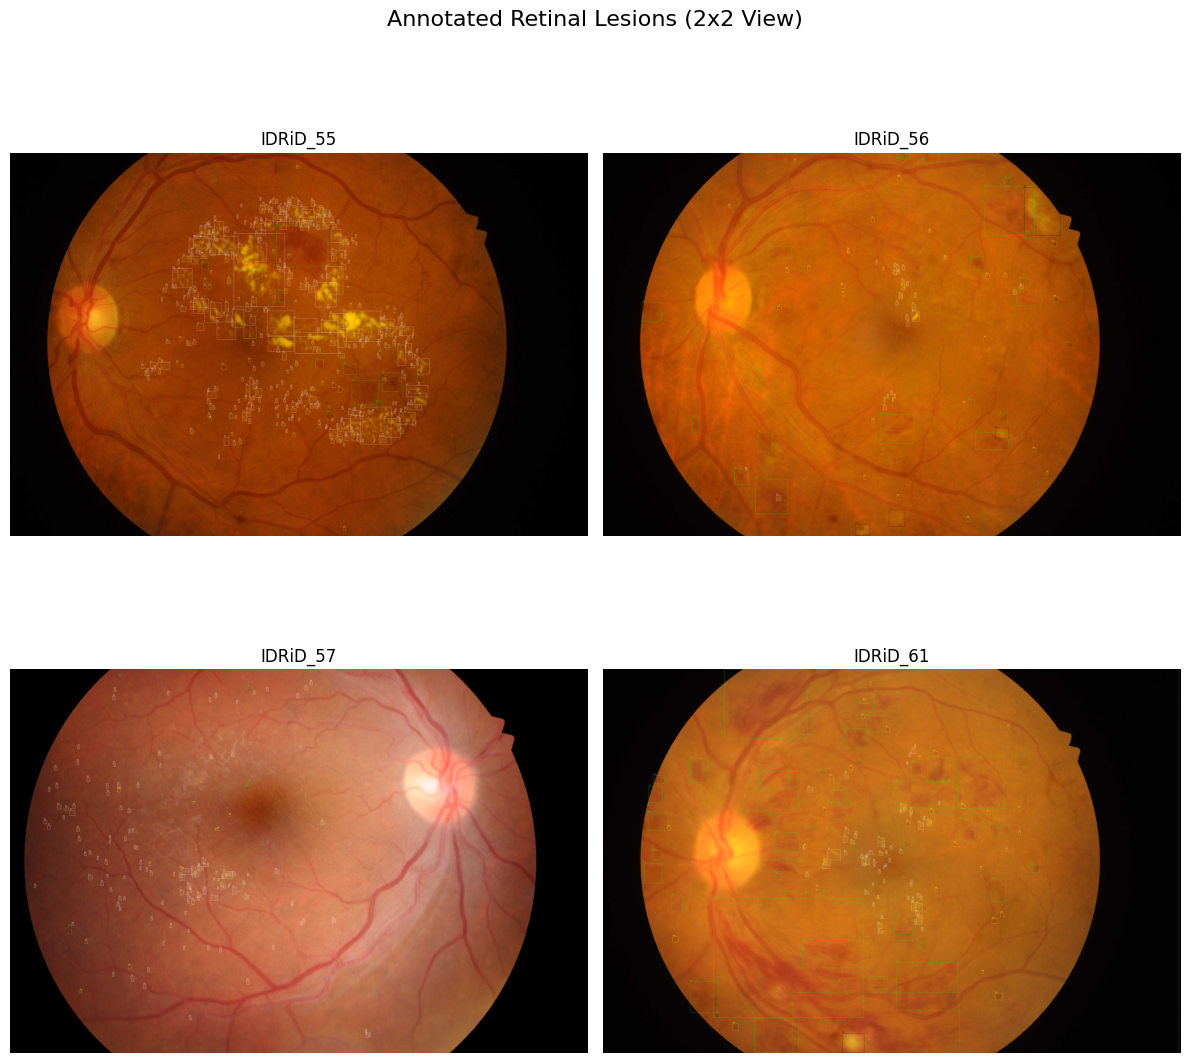

In [22]:
image_dir = r"/kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/images/val"
label_dir = r"/kaggle/working/FIRST YOLO_DIABETIC RETINOPATHY/data/labels/val"

image_ids = ["IDRiD_55", "IDRiD_56", "IDRiD_57", "IDRiD_61"]

class_map = {
    0: ("MA", (0, 255, 255)),     # Cyan
    1: ("HE", (0, 255, 0)),      # Green
    2: ("EX", (255, 255, 255)),  # White 
    3: ("SE", (0, 0, 0)),        # Black
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for idx, image_id in enumerate(image_ids):
    img_path = os.path.join(image_dir, image_id + ".jpg")
    label_path = os.path.join(label_dir, image_id + ".txt")

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()
    else:
        lines = []

    for line in lines:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        label, color = class_map[int(cls)]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)
        cv2.putText(img, label, (x1, max(y1 - 5, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1) #increase 0.4 to higher number if you want to see labeling but there are too many so its clustered

    axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(image_id)
    axes[idx].axis("off")

plt.suptitle("Annotated Retinal Lesions (2x2 View)", fontsize=16)
plt.tight_layout()
plt.show()

# Zoom to see the bounding boxes in the images above.